In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve 
from yellowbrick.classifier import ROCAUC


#prepr auto sklearn
from collections import Counter
import io
import warnings
warnings.filterwarnings('ignore')

In [24]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

for _ in range(3):
    try:
        import autosklearn.classification
        break
    except:
        pass
else:
    raise ImportError("failed to import from autosklearn")


Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   206  100   206    0     0   1548      0 --:--:-- --:--:-- --:--:--  1548


## Injestion 

In [25]:
df = pd.read_csv("https://raw.githubusercontent.com/SridharCR/Diabetes_Prediction/master/Data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data Type: Diabetes
2. Dataset size: 768
3. Number of features: 7
4. Features:
4.1. Pregnancies: Number of times pregnant
4.2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
4.3. BloodPressure: Diastolic blood pressure (mm Hg)
4.4. SkinThickness: Triceps skin fold thickness (mm)
4.5. Insulin: 2-Hour serum insulin (mu U/ml)
4.6. BMI: Body mass index (weight in kg/(height in m)^2)
4.7. DiabetesPedigreeFunction: Diabetes pedigree function
4.8. Age: Age (years)
4.9. Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [27]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## EDA

In [28]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

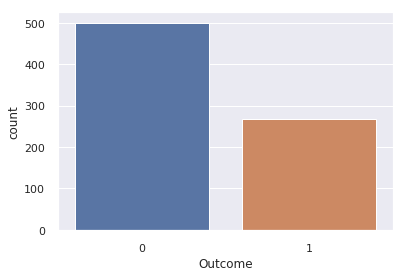

In [29]:
sns.countplot(x="Outcome", data=df)
plt.show()

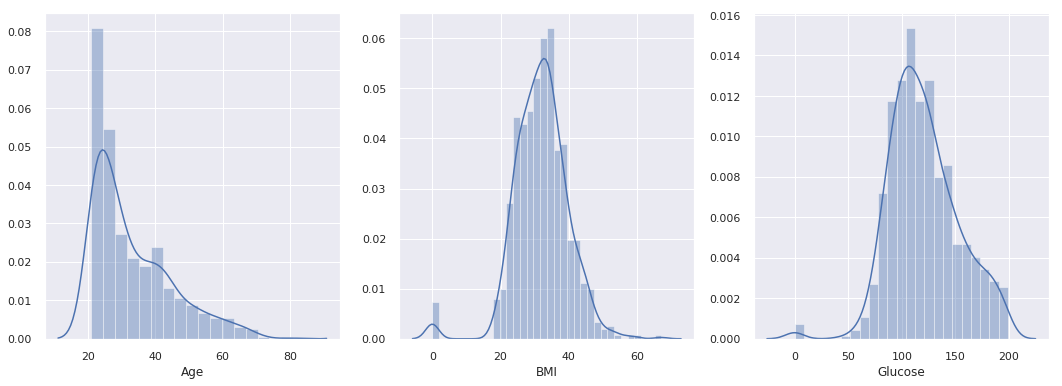

In [30]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.distplot(df['Age'])

plt.subplot(1,3,2)
sns.distplot(df['BMI'])

plt.subplot(1,3,3)
sns.distplot(df['Glucose'])



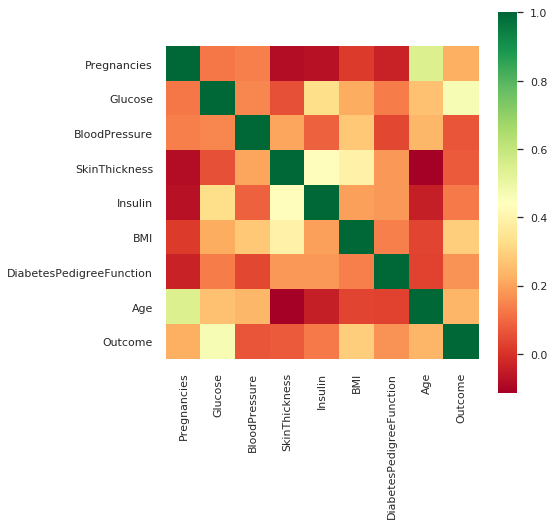

In [31]:
sns.set(rc={'figure.figsize':(7,7)})

sns.heatmap(df.iloc[:,:].corr(), square=True, cmap='RdYlGn')


In [32]:
# slope, fbs, chol are not so correlated with target, so exclude them from the modeling 
df_filtered = df.drop(['Outcome'], axis=1)
df_filtered.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


## Model


In [0]:
X = df_filtered
y = df.Outcome

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)


### Logistic Regression

In [34]:
# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Grid Search for Logistic Regression

In [0]:
#Create Hyperparameter Search Space
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [0]:
#Create Grid Search
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

In [37]:
clf

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
#Conduct Grid Search
# Fit grid search
best_model = clf.fit(X_train, y_train)

In [39]:
#View Hyperparameter Values Of Best Model
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 1.0


In [40]:
#Predict Using Best Model
# Predict target vector
y_pred_log = best_model.predict(X_test)
y_pred_log

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

#### Accessment and interpretation of the best model selected

In [41]:

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_log))
print('-----')
print(classification_report(y_test, y_pred_log))

[[167  39]
 [ 38  64]]
-----
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       206
           1       0.62      0.63      0.62       102

   micro avg       0.75      0.75      0.75       308
   macro avg       0.72      0.72      0.72       308
weighted avg       0.75      0.75      0.75       308



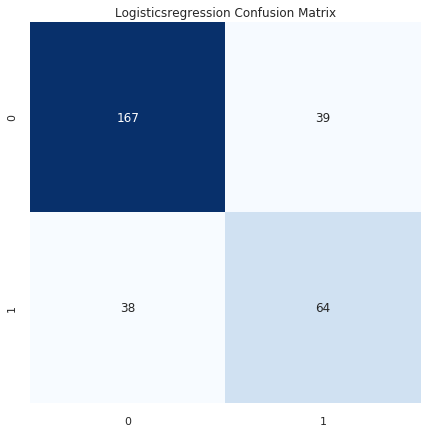

In [46]:
plt.title("Logisticsregression Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_log),annot=True,cmap="Blues",fmt="d",cbar=False)

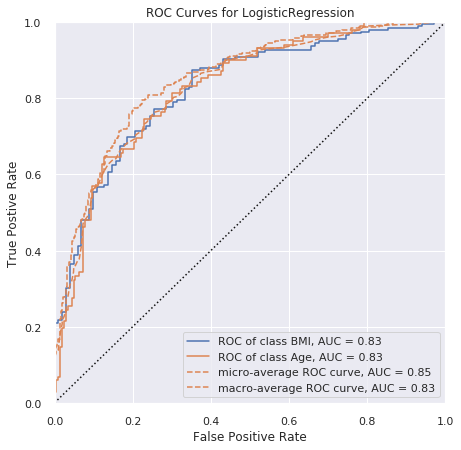

In [42]:
classes = ["BMI", "Age"]
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(LogisticRegression(), classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

#### Interpretation performance - from business impact viewpoint (false negatives vs false positives)

precision = True Positive / (True Positive + False Positive)
recall = True Positive / (True Positive + False Negative)

*The precision of 0.75 indicates that 75% of classified diabetes are actually having diabetes. This is a relative ok precision but in real case, 
this type I error (25%) will waste medical resources and cases unecessary burdon to the patient.*

*The Recall of 0.75 indicates that 84% of patients with diabetes will be correctly detected but 25% will miss. This 25% is type II error. In this case, the 
25% miscclassifcation means delay of treatment because the algorithem failed to detect them. Given this analysis, this model needs improvement.*

### SVM

We have divided the data into training and testing sets. Now is the time to train our SVM on the training data. Scikit-Learn contains the svm library, which contains built-in classes for different SVM algorithms. Since we are going to perform a classification task, we will use the support vector classifier class, which is written as SVC in the Scikit-Learn's svm library. This class takes one parameter, which is the kernel type. This is very important. In the case of a simple SVM we simply set this parameter as "linear" since simple SVMs can only classify linearly separable data. We will see non-linear kernels in the next section.

The fit method of SVC class is called to train the algorithm on the training data, which is passed as a parameter to the fit method. Execute the following code to train the algorithm:

In [43]:
svm = SVC(kernel='linear')  
svm.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [44]:
#Grid Search
parameters = {'kernel':('linear', 'rbf'), 'C':(1,0.25,0.5,0.75),'gamma': (1,2,3,'auto'),'decision_function_shape':('ovo','ovr'),'shrinking':(True,False)}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf'), 'C': (1, 0.25, 0.5, 0.75), 'gamma': (1, 2, 3, 'auto'), 'decision_function_shape': ('ovo', 'ovr'), 'shrinking': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
clf.best_params_

{'C': 1,
 'decision_function_shape': 'ovo',
 'gamma': 1,
 'kernel': 'linear',
 'shrinking': True}

In [49]:
y_pred_SVC = svm.predict(X_test)  
y_pred_SVC

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

#### Accessment and interpretation of the best model selected

In [50]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_SVC))
print('-----')
print(classification_report(y_test, y_pred_SVC))

[[172  34]
 [ 38  64]]
-----
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       206
           1       0.65      0.63      0.64       102

   micro avg       0.77      0.77      0.77       308
   macro avg       0.74      0.73      0.73       308
weighted avg       0.76      0.77      0.77       308



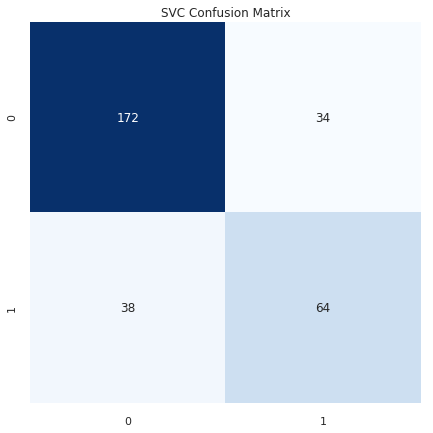

In [51]:
plt.title("SVC Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_SVC),annot=True,cmap="Blues",fmt="d",cbar=False)

#### Interpretation performance - from business impact viewpoint (false negatives vs false positives)

*The precision of 0.76 indicates that 76% of classified diabetes are actually having diabetes. This is a relative ok precision but in real case, 
this type I error (24%) will waste medical resources and cases unecessary burdon to the patient.*

*The Recall of 0.77 indicates that 77% of patients with diabetes will be correctly detected but 23% will miss. This 23% is type II error. In this case, the 
23% miscclassifcation means delay of treatment because the algorithem failed to detect them. Given this analysis, this model needs improvement.*

The Type II error will be more dangers in this business application. 

### Random Forest Classifier


In [52]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
CV_rfc.best_params_


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [0]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [55]:

rfc1.fit(X_train, y_train)

y_pred_rf=rfc1.predict(X_test)
y_pred_rf

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,

In [56]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_rf))
print('-----')
print(classification_report(y_test, y_pred_rf))

[[175  31]
 [ 35  67]]
-----
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       206
           1       0.68      0.66      0.67       102

   micro avg       0.79      0.79      0.79       308
   macro avg       0.76      0.75      0.76       308
weighted avg       0.78      0.79      0.78       308



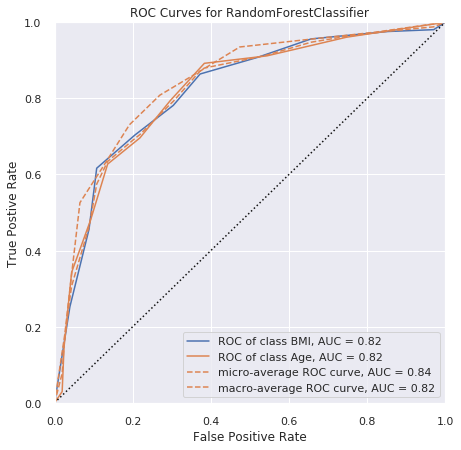

In [57]:
classes = ["BMI", "Age"]
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(RandomForestClassifier(random_state=42), classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

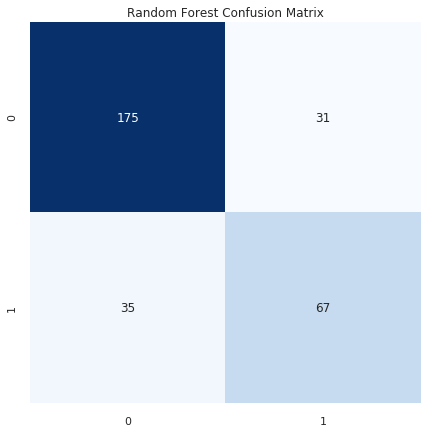

In [58]:
plt.title("Random Forest Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_rf),annot=True,cmap="Blues",fmt="d",cbar=False)

#### Interpretation performance - from business impact viewpoint (false negatives vs false positives)


*The precision of 0.78 indicates that 78% of classified diabetes are actually having diabetes. This is a relative ok precision but in real case, 
this type I error (22%) will waste medical resources and cases unecessary burdon to the patient.*

*The Recall of 0.75 indicates that 79% of patients with diabetes will be correctly detected but 21% will miss. This 21% is type II error. In this case, the 
21% miscclassifcation means delay of treatment because the algorithem failed to detect them. Given this analysis, this model needs improvement.*

The Type II error will be more dangers in this business application. 


## Model Comparison, Logistic Regression vs. SVM vs. Random Forest

Below table is the model performance of three models obtained with GridSearch with 5 folds. We can see that **Random Forest outperforms the other models on all four performance metrics (Precisision, Recall, F1-score, Support).**



|Indicators - Weighted Avg | LogisticRegression|  SVM|  Random Forest|
| ------------- |-------------|------------- |-------------|
|Precision| 0.75 |0.76| 0.78|
|Recalls |0.75| 0.77| 0.79|
|F1-Score |0.75 |0.77 |0.78|
|Support| 308| 308| 308|


In the case of identifying high-risk population, we think false negative error(Recall) is more important than false positive (Precision). Prevention cost is much lower than medical treatment cost, so we want to identify as much high-risk people as possible. We can see that Random Forest performs very well compared with Logistic Regression and SVM.

## Auto ML

In [0]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train, y_train)

![alt text](https://pbs.twimg.com/media/D5JdYIDUEAAL-jM?format=jpg&name=medium)

In [0]:
y_hat = automl.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

![alt text](https://pbs.twimg.com/media/D5JdsQvU4AAjDn3?format=jpg&name=medium)

## H2O AutoML

In [60]:
!pip install -U h2o

     |████████████████████████████████| 121.0MB 136kB/s 
  Stored in directory: /root/.cache/pip/wheels/e9/92/d1/61cddd17defd8ba2a10400d2b3adf917377769610d904c279d
Successfully built h2o


In [61]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

train = h2o.import_file("https://raw.githubusercontent.com/SridharCR/Diabetes_Prediction/master/Data/diabetes.csv")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment (build 11.0.2+9-Ubuntu-3ubuntu118.04.3); OpenJDK 64-Bit Server VM (build 11.0.2+9-Ubuntu-3ubuntu118.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8wbb9eiz
  JVM stdout: /tmp/tmp8wbb9eiz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8wbb9eiz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,16 days
H2O cluster name:,H2O_from_python_unknownUser_pamdjj
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [62]:
x = train.columns
y='Outcome'

x.remove(y)

train[y] = train[y].asfactor()

aml = H2OAutoML(max_runtime_secs = 30)
aml.train(x=x, y=y, training_frame = train)

lb = aml.leaderboard
lb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_2_AutoML_20190503_205913,0.829571,0.485164,0.24694,0.399732,0.159785
StackedEnsemble_BestOfFamily_AutoML_20190503_205913,0.828504,0.487276,0.245,0.399914,0.159931
XGBoost_1_AutoML_20190503_205913,0.828414,0.482525,0.240478,0.398518,0.158817
StackedEnsemble_AllModels_AutoML_20190503_205913,0.826142,0.490468,0.247657,0.401016,0.160814
GLM_grid_1_AutoML_20190503_205913_model_1,0.826037,0.487573,0.251343,0.398139,0.158515
XGBoost_3_AutoML_20190503_205913,0.82603,0.487628,0.233612,0.400189,0.160151
GBM_5_AutoML_20190503_205913,0.823216,0.489056,0.247075,0.401771,0.16142
GBM_2_AutoML_20190503_205913,0.821175,0.497525,0.242134,0.403389,0.162723
GBM_1_AutoML_20190503_205913,0.819019,0.505579,0.255269,0.406651,0.165365
GBM_4_AutoML_20190503_205913,0.817153,0.5017,0.241493,0.406448,0.1652


In [63]:
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190503_205913


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13433604018329237
RMSE: 0.3665188128640771
LogLoss: 0.4245506426379742
Mean Per-Class Error: 0.1862089552238806
AUC: 0.8866417910447761
pr_auc: 0.7932779112604309
Gini: 0.7732835820895523
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42397576570510864: 


,0,1,Error,Rate
0,422.0,78.0,0.156,(78.0/500.0)
1,58.0,210.0,0.2164,(58.0/268.0)
Total,480.0,288.0,0.1771,(136.0/768.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4239758,0.7553957,182.0
max f2,0.1979461,0.8269720,295.0
max f0point5,0.4366751,0.7442197,175.0
max accuracy,0.4366751,0.8242188,175.0
max precision,0.8660378,1.0,0.0
max recall,0.0882085,1.0,370.0
max specificity,0.8660378,1.0,0.0
max absolute_mcc,0.4239758,0.6178828,182.0
max min_per_class_accuracy,0.4011450,0.8022388,192.0
max mean_per_class_accuracy,0.4239758,0.8137910,182.0


Gains/Lift Table: Avg response rate: 34.90 %, avg score: 36.02 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0104167,0.8471181,2.8656716,2.8656716,1.0,0.8561838,1.0,0.8561838,0.0298507,0.0298507,186.5671642,186.5671642
,2,0.0208333,0.8389885,2.5074627,2.6865672,0.875,0.8431900,0.9375,0.8496869,0.0261194,0.0559701,150.7462687,168.6567164
,3,0.03125,0.8313563,2.1492537,2.5074627,0.75,0.8358037,0.875,0.8450592,0.0223881,0.0783582,114.9253731,150.7462687
,4,0.0403646,0.8192844,2.4562900,2.4959076,0.8571429,0.8256855,0.8709677,0.8406845,0.0223881,0.1007463,145.6289979,149.5907559
,5,0.0507812,0.8080888,2.8656716,2.5717566,1.0,0.8140334,0.8974359,0.8352176,0.0298507,0.1305970,186.5671642,157.1756602
,6,0.1002604,0.7514930,2.5640220,2.5679395,0.8947368,0.7799986,0.8961039,0.8079667,0.1268657,0.2574627,156.4021995,156.7939523
,7,0.1510417,0.6862514,2.4247991,2.5198147,0.8461538,0.7210091,0.8793103,0.7787309,0.1231343,0.3805970,142.4799082,151.9814720
,8,0.2005208,0.6053475,2.1869599,2.4376817,0.7631579,0.6504865,0.8506494,0.7470862,0.1082090,0.4888060,118.6959937,143.7681721
,9,0.3007812,0.4969121,1.6747432,2.1833689,0.5844156,0.5533620,0.7619048,0.6825115,0.1679104,0.6567164,67.4743167,118.3368870
,10,0.3997396,0.3997526,1.4705420,2.0069036,0.5131579,0.4480527,0.7003257,0.6244696,0.1455224,0.8022388,47.0542027,100.6903593




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.15978546430190374
RMSE: 0.3997317404233791
LogLoss: 0.4851637375137419
Mean Per-Class Error: 0.24694029850746269
AUC: 0.829570895522388
pr_auc: 0.6883827846437528
Gini: 0.6591417910447761
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35669054090976715: 


,0,1,Error,Rate
0,365.0,135.0,0.27,(135.0/500.0)
1,60.0,208.0,0.2239,(60.0/268.0)
Total,425.0,343.0,0.2539,(195.0/768.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3566905,0.6808511,207.0
max f2,0.1794487,0.8012422,305.0
max f0point5,0.6612066,0.6770833,76.0
max accuracy,0.5475082,0.7630208,115.0
max precision,0.8820634,1.0,0.0
max recall,0.0618882,1.0,391.0
max specificity,0.8820634,1.0,0.0
max absolute_mcc,0.3733556,0.4870125,195.0
max min_per_class_accuracy,0.3674048,0.7462687,200.0
max mean_per_class_accuracy,0.3566905,0.7530597,207.0


Gains/Lift Table: Avg response rate: 34.90 %, avg score: 35.84 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0104167,0.8350086,1.7910448,1.7910448,0.625,0.8522170,0.625,0.8522170,0.0186567,0.0186567,79.1044776,79.1044776
,2,0.0208333,0.8198319,2.5074627,2.1492537,0.875,0.8263641,0.75,0.8392905,0.0261194,0.0447761,150.7462687,114.9253731
,3,0.03125,0.7994456,2.5074627,2.2686567,0.875,0.8096180,0.7916667,0.8293997,0.0261194,0.0708955,150.7462687,126.8656716
,4,0.0403646,0.7880044,2.8656716,2.4034665,1.0,0.7918772,0.8387097,0.8209269,0.0261194,0.0970149,186.5671642,140.3466538
,5,0.0507812,0.7742231,2.1492537,2.3513203,0.75,0.7811403,0.8205128,0.8127655,0.0223881,0.1194030,114.9253731,135.1320321
,6,0.1002604,0.7259732,2.3377848,2.3446404,0.8157895,0.7518168,0.8181818,0.7826869,0.1156716,0.2350746,133.7784760,134.4640434
,7,0.1510417,0.6745730,2.3513203,2.3468863,0.8205128,0.7017748,0.8189655,0.7554837,0.1194030,0.3544776,135.1320321,134.6886258
,8,0.2005208,0.5983404,1.5082482,2.1399496,0.5263158,0.6362330,0.7467532,0.7260582,0.0746269,0.4291045,50.8248233,113.9949603
,9,0.3007812,0.4742332,1.4886606,1.9228533,0.5194805,0.5359724,0.6709957,0.6626963,0.1492537,0.5783582,48.8660593,92.2853266
,10,0.3997396,0.3817540,1.3574234,1.7828771,0.4736842,0.4308914,0.6221498,0.6053114,0.1343284,0.7126866,35.7423409,78.2877145



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.7434428,0.0133307,0.7662337,0.7337663,0.7662337,0.7254902,0.7254902
auc,0.8287955,0.0190077,0.8421336,0.8309038,0.8664966,0.8194974,0.7849463
err,0.2565572,0.0133307,0.2337662,0.2662338,0.2337662,0.2745098,0.2745098
err_count,39.4,1.9798989,36.0,41.0,36.0,42.0,42.0
f0point5,0.6316262,0.0224143,0.6818182,0.6318681,0.591716,0.6056701,0.6470588
f1,0.692754,0.0085286,0.7142857,0.6917293,0.6896552,0.6911765,0.6769231
f2,0.7710075,0.0290949,0.75,0.7641196,0.8264463,0.8047945,0.7096774
lift_top_group,2.251932,0.3583795,2.6551723,2.75,1.8333334,1.4711539,2.55
logloss,0.4852559,0.0292054,0.4797001,0.4859456,0.4193125,0.4920017,0.5493199
max_per_class_error,0.3010776,0.0295662,0.2395833,0.3163265,0.3035714,0.3663366,0.2795699


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-05-03 20:59:22,2.586 sec,0.0,0.5,0.6931472,0.5,0.0,1.0,0.6510417
,2019-05-03 20:59:22,2.635 sec,5.0,0.4642535,0.6236512,0.8559216,0.6994204,2.5472637,0.2135417
,2019-05-03 20:59:22,2.654 sec,10.0,0.4407966,0.5791521,0.8682388,0.7577908,2.5074627,0.2083333
,2019-05-03 20:59:22,2.682 sec,15.0,0.4220501,0.5434249,0.8735149,0.7654336,2.5472637,0.1979167
,2019-05-03 20:59:22,2.720 sec,20.0,0.4068393,0.5137615,0.8780336,0.7715551,2.5074627,0.1861979
,2019-05-03 20:59:22,2.756 sec,25.0,0.3947819,0.4892044,0.8782910,0.7711868,2.5074627,0.1861979
,2019-05-03 20:59:22,2.783 sec,30.0,0.3863561,0.4710515,0.8789216,0.7771145,2.5074627,0.1953125
,2019-05-03 20:59:22,2.813 sec,35.0,0.3803773,0.4575765,0.8799067,0.7778896,2.5074627,0.2005208
,2019-05-03 20:59:22,2.847 sec,40.0,0.3752092,0.4459577,0.8820560,0.7809670,2.8656716,0.1822917
,2019-05-03 20:59:22,2.874 sec,45.0,0.3718913,0.4377618,0.8835075,0.7835226,2.8656716,0.1796875


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Glucose,1137.8546143,1.0,0.4648359
BMI,464.7205200,0.4084182,0.1898475
Age,351.0335999,0.3085048,0.1434041
DiabetesPedigreeFunction,152.6303406,0.1341387,0.0623525
Pregnancies,104.5860367,0.0919151,0.0427254
Insulin,95.6326218,0.0840464,0.0390678
SkinThickness,83.9811554,0.0738066,0.0343079
BloodPressure,57.4239578,0.0504669,0.0234588


In [64]:
test = h2o.import_file("https://raw.githubusercontent.com/Barneybean/diebeties_classification/master/diabetes_test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [66]:
test[y] = test[y].asfactor()

y_pred = aml.leader.predict(test)
y_pred

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
0,0.73821,0.26179
0,0.893333,0.106667
1,0.307754,0.692246
0,0.633308,0.366692
0,0.834535,0.165465
0,0.664038,0.335962
0,0.778659,0.221341
0,0.679663,0.320337
0,0.883081,0.116919
0,0.631871,0.368129


## Canvas 

In [67]:
from IPython.display import Image
from google.colab import files
uploaded = files.upload()


Saving Canvas.png to Canvas.png


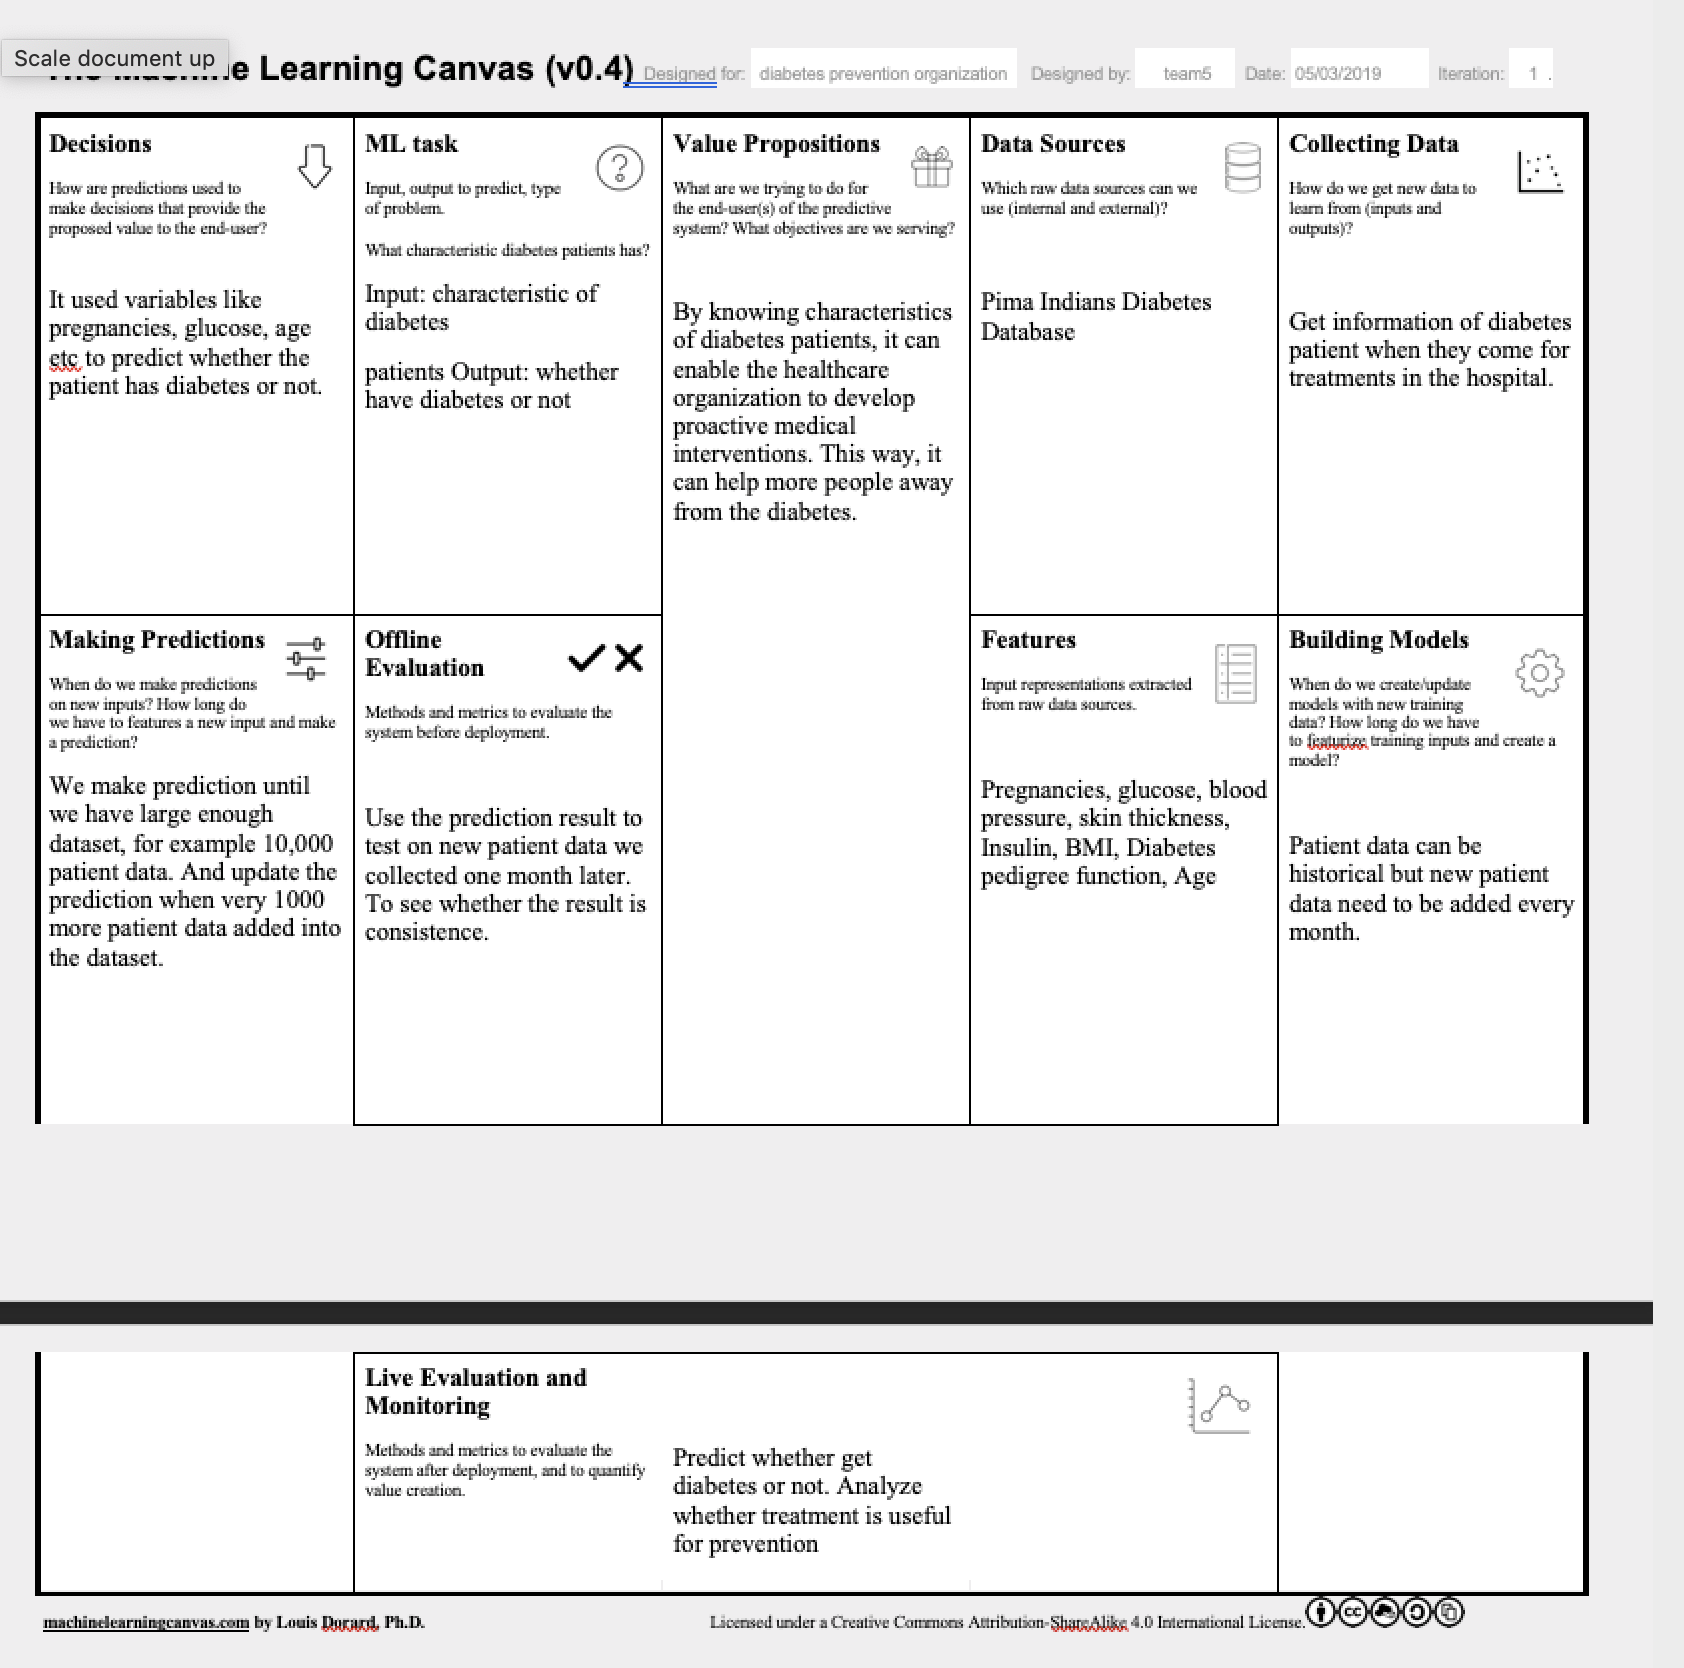

In [68]:
Image("Canvas.png", width=700)